Task 1
If you were asked to build a model for predicting arousal and valence, using the provided audio
features as explanatory variables:

1. Which performance metrics would you use to evaluate your model’s predictions?

2. Does the selection of the performance metric depend on the type of the response
variables? Explain your reasoning.

3. Which validation protocol (e.g., holdout set, k-fold cross-validation, etc.) would you
use given that the objective is to build a predictive model able to generalise across
participants (i.e., make accurate predictions for unseen participants)? Justify your
choice.

Task 2 Using the provided audio features, build predictive models for arousal and valence:

1. Develop a predictive model for each response variable (arousal and valence) using
some or all of the provided audio features as explanatory variables

Before constructing our predictive models, we preprocessed the dataset using feature selection. We separated the target variables, median_arousal and median_valence, from the feature set. These will serve as the outputs our models aim to predict and therefore should not be included in the training dataset, hence we separated them for labelling. We also excluded the Participant ID as this is a categorical identifier unique to each individual, including this as a feature would leave the model to learn participant-specific patterns rather than generalizable trends and possibly result in overfitting

However, the Participant ID plays a crucial role during model evaluation. To simulate real-world scenarios where the model encounters data from unseen and individual, we employ a cross-validation strategy known as leave-one-out (LOO) ensures data from each participant is used exclusively in either the training or testing set. Like this we can be sure that no data leakage could occur during training, if we simply split a participants recordings into a trainig and test setsthe model may easily perform unrealisitically well (given it already has training knowledge regarding them), rather than a real life scenario where an unseen participant would need to be identified.

We then used the standard scaler to scale the data, naturally there is no need to do this on the target variables as they are median values.

In [106]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random

# Load and scale data
df = pd.read_csv("project_data.csv")
scaler = StandardScaler()

y_arousal = pd.concat([df['Participant'], df['median_arousal']], axis=1)
y_valence = pd.concat([df['Participant'], df['median_valence']], axis=1)
df = df.drop(columns=['median_arousal', 'median_valence'])

# Get participant list
last_participant = df.iloc[[-1]]
participant_list = list(range(1, int(last_participant['Participant']) + 1))

# 80/20 test-train split
test_participants_index = random.sample(participant_list, 2)
train_participants_index = [item for item in participant_list if item not in test_participants_index]

x_test = pd.concat([df[df['Participant'] == index] for index in test_participants_index])
x_train = pd.concat([df[df['Participant'] == index] for index in train_participants_index])
y_test_arousal = pd.concat([y_arousal[y_arousal['Participant'] == index] for index in test_participants_index])
y_test_valence = pd.concat([y_valence[y_valence['Participant'] == index] for index in test_participants_index])
y_train_arousal = pd.concat([y_arousal[y_arousal['Participant'] == index] for index in train_participants_index])
y_trian_valence = pd.concat([y_valence[y_valence['Participant'] == index] for index in train_participants_index]) 

x_test = x_test.drop(columns=['Participant'])
x_train = x_train.drop(columns=['Participant'])
y_test_arousal = y_test_arousal.drop(columns=['Participant'])
y_test_valence = y_test_valence.drop(columns=['Participant'])
y_train_arousal = y_train_arousal.drop(columns=['Participant'])
y_trian_valence = y_trian_valence.drop(columns=['Participant'])

x_test_scaled = scaler.fit_transform(x_test)
x_train_scaled = scaler.fit_transform(x_train)

C:\Users\gianm\AppData\Local\Temp\ipykernel_25240\3097591752.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  participant_list = list(range(1, int(last_participant['Participant']) + 1))


The first task when selecticg a model is to identify if the problem is a regression or classification problem, given that we have to predict scaler values (median valence and arousal) this is clearly a regression problem. The next step is to recognize that the dataset presents a high-dimensionality problem. Traditional machine learning methods often struggle to handle high-dimensional data effectively. We would also like some level of explainability to ensure the rationality behind the model, specifically jow specific audio features influence emotional states.

For this we settled on Lasso Regularized Generalized Linear Model (GLM) due to the high dimnsionality of the problem. Lasso regularization penalizes features to effectively exclude temselves by reducing them to zero, hence its inclusing in feature selection.

In [ ]:
from sklearn.linear_model import LassoCV

lasso_cv_arousal = LassoCV(cv=10, random_state=0)
lasso_cv_arousal.fit(x_train_scaled, y_train_arousal.values.ravel())
selected_features_mask_arousal = lasso_cv_arousal.coef_ != 0
x_train_selected_arousal = x_train_scaled[:, selected_features_mask_arousal]
x_test_selected_arousal = x_test_scaled[:, selected_features_mask_arousal]

lasso_cv_valence = LassoCV(cv=10, random_state=0)
lasso_cv_valence.fit(x_train_scaled, y_trian_valence.values.ravel())
selected_features_mask_valence = lasso_cv_valence.coef_ != 0
x_train_selected_valence = x_train_scaled[:, selected_features_mask_valence]
x_test_selected_valence = x_test_scaled[:, selected_features_mask_valence]

print("Selected features by Lasso:\n", selected_features_mask_arousal.tolist())
print("Selected features by Lasso:\n", selected_features_mask_valence.tolist())

c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03331109793811038, tolerance: 0.01736638896819322
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0677389936986259, tolerance: 0.01736638896819322
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04838227554003538, tolerance: 0.01736638896

Arousal MSE: 19
Valence MSE: 11
Selected features by Lasso:
 [False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, True, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, True, False, True, False, False, True, False, False, False, False, False, False, False, False, False]
Selected features by Lasso:
 [False, False, Fal

c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12785822192159202, tolerance: 0.006336516070440696
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14619938602685778, tolerance: 0.006336516070440696
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16707695573767722, tolerance: 0.00633651

Iterative Generalized Linear Models (GLMs), offer a compelling balance between interpretability and efficiency, making them especially valuable in scenarios where understanding feature effects is as important as predictive accuracy. Unlike Random Forests and Support Vector Machine,  which often function as black-box models with limited transparency, Iterative GLMs provide explicit model coefficients that quantify the relationship between each input feature and the target variable. Compared to standard Logistic or Linear Regression, Iterative GLMs are more flexible and stable in handling non-Gaussian distributions and can provide more reliable estimates through their iterative fitting process. 

In [108]:
import statsmodels.api as sm

x_train_glm_valence = sm.add_constant(x_train_selected_valence)
x_test_glm_valence = sm.add_constant(x_test_selected_valence)
x_train_glm_arousal = sm.add_constant(x_train_selected_arousal)
x_test_glm_arousal = sm.add_constant(x_test_selected_arousal)

glm_model_arousal = sm.GLM(y_train_arousal.values.ravel(), x_train_glm_arousal, family=sm.families.Gaussian())
glm_results_arousal = glm_model_arousal.fit()
glm_model_valence = sm.GLM(y_trian_valence.values.ravel(), x_train_glm_valence, family=sm.families.Gaussian())
glm_results_valence = glm_model_valence.fit()


glm_predictions_valence = glm_results_valence.predict(x_test_glm_valence)
glm_predictions_arousal = glm_results_arousal.predict(x_test_glm_arousal)

In [109]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

glm_mse_valence = mean_squared_error(y_test_valence, glm_predictions_valence)
glm_mse_arousal = mean_squared_error(y_test_arousal, glm_predictions_arousal)
glm_rmse_valence =  np.sqrt(glm_mse_valence)
glm_rmse_arousal =  np.sqrt(glm_mse_arousal)
r2_valence = r2_score(y_test_valence, glm_predictions_valence)
r2_arousal = r2_score(y_test_arousal, glm_predictions_arousal)

print(glm_results_arousal.summary())
print(f"\nGLM MSE (arousal): {glm_mse_arousal:.4f}")
print(f"\nGLM RMSE (arousal): {glm_rmse_arousal:.4f}")
print(f"\nGLM R^2 (arousal): {r2_arousal:.4f}")
print(glm_results_valence.summary())
print(f"\nGLM MSE (valence): {glm_mse_valence:.4f}")
print(f"\nGLM RMSE (valence): {glm_rmse_valence:.4f}")
print(f"\nGLM R^2 (valence): {r2_valence:.4f}")



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5790
Model:                            GLM   Df Residuals:                     5770
Model Family:                Gaussian   Df Model:                           19
Link Function:               Identity   Scale:                        0.024227
Method:                          IRLS   Log-Likelihood:                 2564.6
Date:                Sun, 18 May 2025   Deviance:                       139.79
Time:                        16:38:17   Pearson chi2:                     140.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2973
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0162      0.002     -7.924      0.0

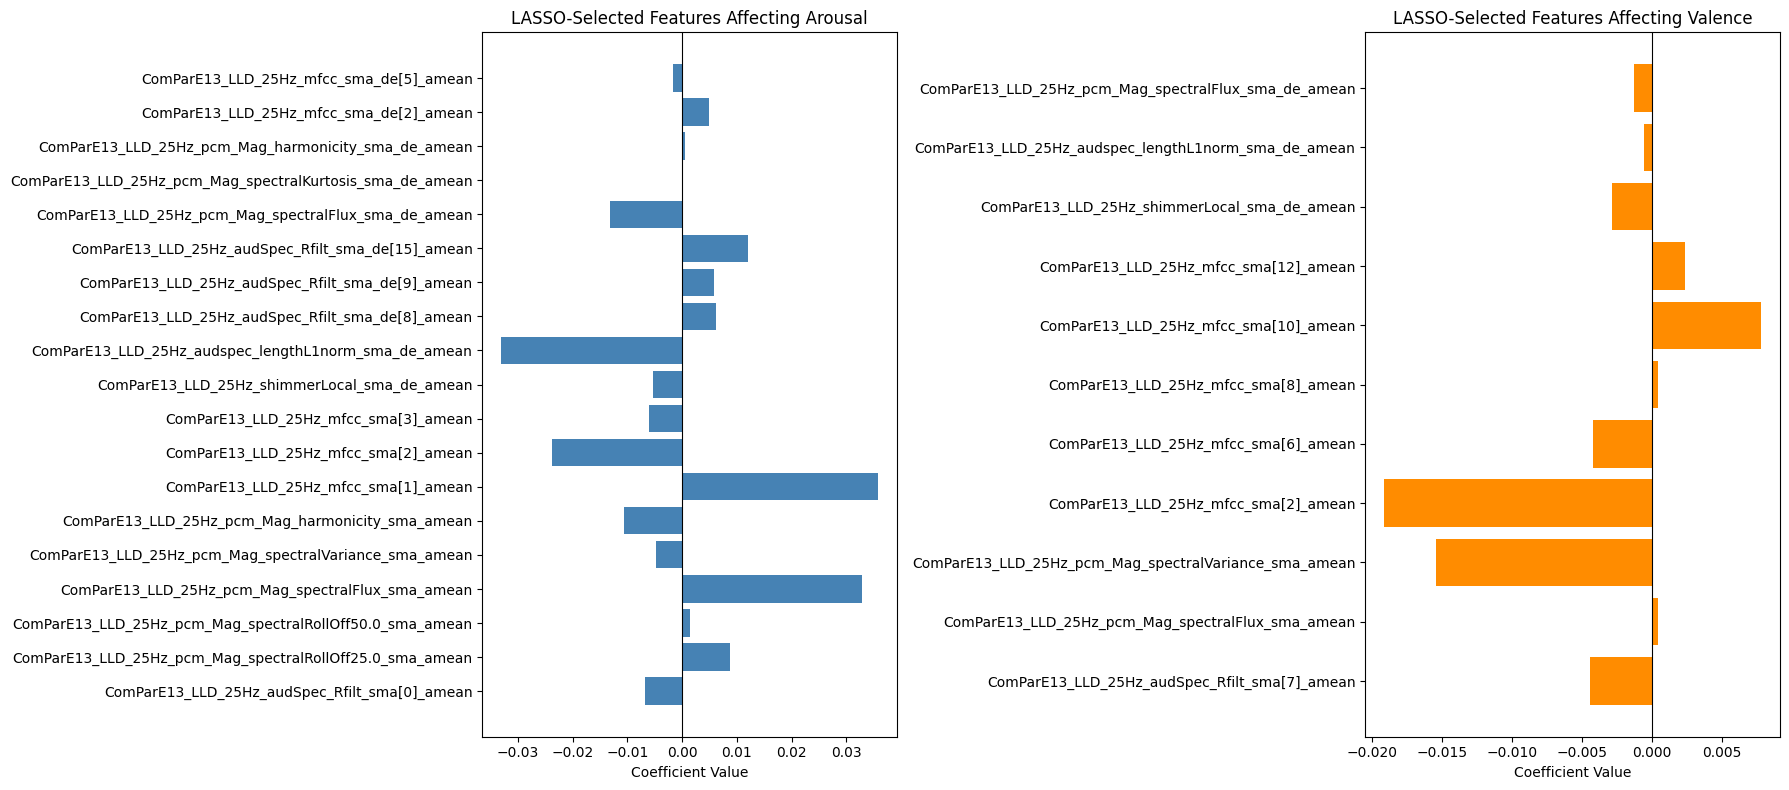

In [ ]:
import matplotlib.pyplot as plt
lasso_coef_arousal = lasso_cv_arousal.coef_
lasso_coef_valence = lasso_cv_valence.coef_
feature_names = x_train.columns
selected_features_arousal = np.array(feature_names)[lasso_coef_arousal != 0]
selected_coefs_arousal = lasso_coef_arousal[lasso_coef_arousal != 0]
selected_features_valence = np.array(feature_names)[lasso_coef_valence != 0]
selected_coefs_valence = lasso_coef_valence[lasso_coef_valence != 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)
axes[0].barh(selected_features_arousal, selected_coefs_arousal, color='steelblue')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_title("LASSO-Selected Features Affecting Arousal")
axes[0].set_xlabel("Coefficient Value")
axes[1].barh(selected_features_valence, selected_coefs_valence, color='darkorange')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title("LASSO-Selected Features Affecting Valence")
axes[1].set_xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

print(f"Number of Features used for Arousal: {len(x_train_selected_arousal[0])}")
print(f"Number of Features used for Valence: {len(x_train_selected_valence[0])}")

 Task 3 
 In  this  task,  you  will  identify  similar  observations  captured  from  the  first  participant 
(participant ID = 1). Complete the following steps: 

1. Create  groups  of  similar  observations  from  the  first  participant  by  proposing  and 
implementing two suitable algorithms. 

We created a subset of the dataset by selecting only participant 1's data, we subsequently dropped the partipants column as this data is uneccassary. We also removed the median_arousal and median_variance as this section is based on creating groups of similar observations (features) and these last two columns are annotations/scores.

In [111]:
import numpy as np
import pandas as pd

df = pd.read_csv("project_data.csv")

participant_df = df[df["Participant"] == 1]
participant_df = participant_df.drop(columns=["Participant",'median_arousal', 'median_valence'])
print(participant_df)

df.to_csv('out.csv',index=False)


     ComParE13_LLD_25Hz_F0final_sma_amean  \
0                               -1.665550   
1                               -1.547531   
2                               -0.977216   
3                               -0.218558   
4                                0.075725   
..                                    ...   
720                              0.834987   
721                              0.995974   
722                              1.229950   
723                              1.597127   
724                              2.174707   

     ComParE13_LLD_25Hz_voicingFinalUnclipped_sma_amean  \
0                                            -1.018178    
1                                            -0.988172    
2                                            -0.724075    
3                                             0.150993    
4                                             0.221303    
..                                                 ...    
720                                           

OSError: [Errno 22] Invalid argument: 'out.csv'

For this question I would like to perform Hierarchical clustering using complete linkage and K-mediods with random initialization to further minimize the optimization criterion along with forward step wise assignment.

     ComParE13_LLD_25Hz_F0final_sma_amean  \
0                               -1.665550   
1                               -1.547531   
2                               -0.977216   
3                               -0.218558   
4                                0.075725   
..                                    ...   
720                              0.834987   
721                              0.995974   
722                              1.229950   
723                              1.597127   
724                              2.174707   

     ComParE13_LLD_25Hz_voicingFinalUnclipped_sma_amean  \
0                                            -1.018178    
1                                            -0.988172    
2                                            -0.724075    
3                                             0.150993    
4                                             0.221303    
..                                                 ...    
720                                           

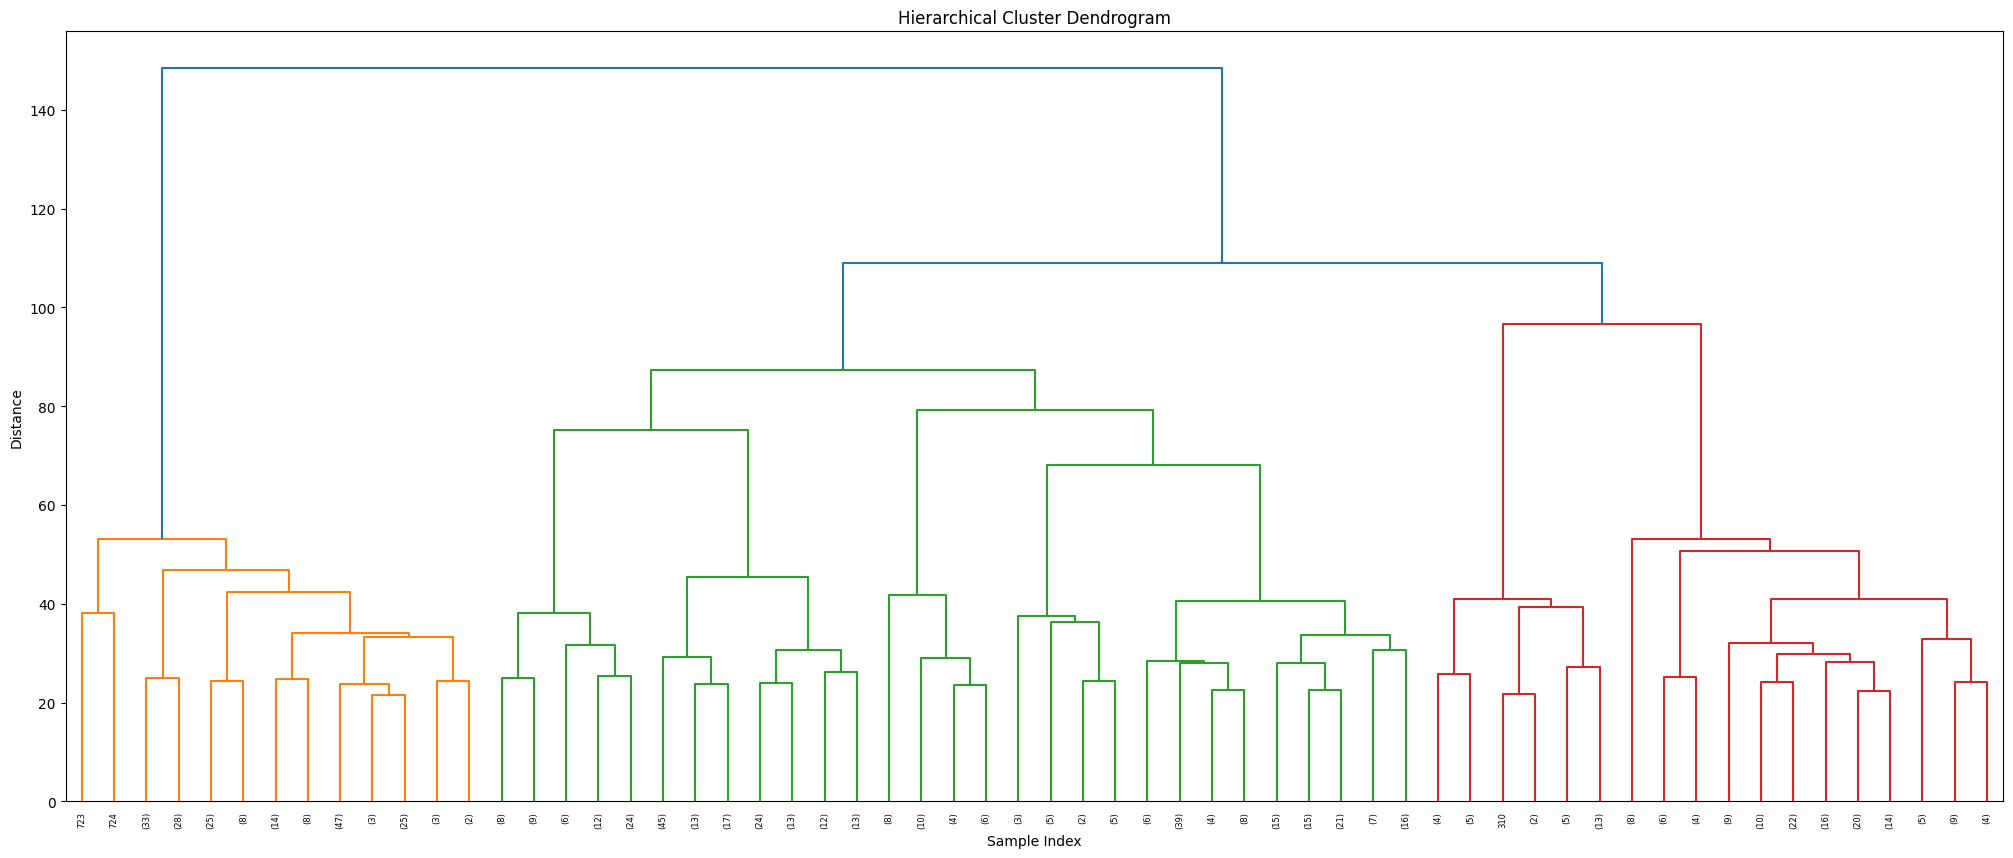

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.cluster.hierarchy import fcluster

from sklearn.datasets import make_blobs

print(participant_df)
plt.figure(figsize=(25,10))
dn = dendrogram(linkage(participant_df,'ward'),truncate_mode='lastp',p=60)
plt.title('Hierarchical Cluster Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

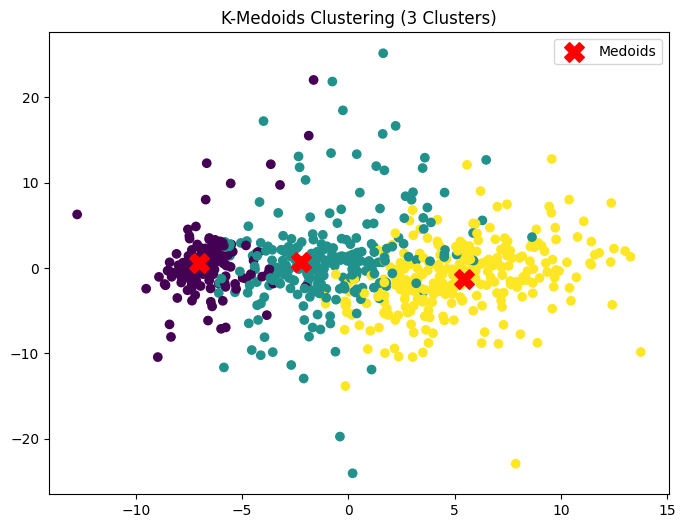

In [ ]:

from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA

#kmedoids = KMedoids(n_clusters=2, random_state=0).fit(X)
kmedoids = KMedoids(n_clusters=3, random_state=42)
labels = kmedoids.fit_predict(participant_df)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(participant_df)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(X_pca[kmedoids.medoid_indices_, 0], X_pca[kmedoids.medoid_indices_, 1], c='red', marker='X', s=200, label='Medoids')
plt.title('K-Medoids Clustering (3 Clusters)')
plt.legend()
plt.show()